# Game Company - Data Modeling

I cleaned and process the data and create a visualizaiton to analyze the data distribution.
I assume purchase rate (purchase times/total online days) can be a KPI and trained a random forest model to predict purchase rate.


### Import Packages and Data

In [8]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import scatter_matrix

In [9]:
#Import Data
play=pd.read_csv('play.csv')
sale=pd.read_csv('sales.csv')

### Data Cleaning and Processing

Get All client_id including client who play the game but purchase nothing, so ID need to be collected from both tables.

In [10]:
client_play=play['ID']
client_sale=sale['ID']
#drop duplicates
client=pd.DataFrame(client_play.append(client_sale)).drop_duplicates()

Get All online date including play date and purchase date

In [11]:
play_date=play.loc[:,['ID','Date']]
sale_date=sale.loc[:,['ID','Date']]
#drop duplicates
all_date=play_date.append(sale_date).drop_duplicates()

Get the Win and Lose information to further analyzing if win or lose will influence customers purchase behaviours

In [12]:
#count win and lose times by client_id
outcome=pd.DataFrame(play.groupby('ID')['Outcome'].value_counts())
#fill the missing value to 0
outcome = outcome['Outcome'].unstack().fillna(0)
#calculate the win percentage
outcome['Win_percentage']=outcome['win']/(outcome['win']+outcome['lose'])*100


The number of matches by platform

In [13]:
platform=pd.DataFrame(play.groupby('ID')['Platform'].value_counts())
#fill the missing value to 0
platform = platform['Platform'].unstack().fillna(0)

Get the each customer's play days, purchase days, online days.

In [14]:
# Online Days / Play Days / Purchase Days  
# Play Days per user (ended a match)
play_day=pd.DataFrame(play.groupby('ID')['Date'].nunique())
# Purchase Days per user (buy something by cash)
purchase_day=pd.DataFrame(sale.groupby('ID')['Date'].nunique())
# Online Days per uer (including play and purchase)
online_day=pd.DataFrame(all_date.groupby('ID')['Date'].nunique())

Calculate the total payment for each client

In [15]:
# Total Paymet per user
total_payment=pd.DataFrame(sale.groupby('ID')['Dollar_Spent'].agg(sum))

Count the number of purchase times for each user

In [16]:
# The number of purchase times per user
purchase_times=pd.DataFrame(sale.groupby('ID')['Dollar_Spent'].count())

Calculate total points for each user

In [20]:
# Total Points per user
total_points=pd.DataFrame(play.groupby('ID')['Experience_Points'].agg(sum))

Count the number of items for each user

In [21]:
# The number of items per user
num_items=pd.DataFrame(sale.groupby('ID')['Product_ID'].nunique())

Merge the table by ID

In [22]:
result=client.merge(play_day,on='ID',how='left') \
             .merge(purchase_day,on='ID',how='left') \
             .merge(online_day,on='ID',how='left') \
             .merge(total_payment,on='ID',how='left') \
             .merge(purchase_times,on='ID',how='left') \
             .merge(num_items,on='ID',how='left') \
             .merge(outcome,on='ID',how='left') \
             .merge(total_points,on='ID',how='left') \
             .merge(platform,on='ID',how='left')            
# Rename
result.columns=["ID",  "play_days",  "purchase_day", "online_days",  "total_payment",  "purchase_times"
               , "num_store_item",  "lose_times",  "win_times" , "win_percentage","total_points","PC","Mobile"]
#Fill Na
result.fillna(0)

,ID,play_days,purchase_day,online_days,total_payment,purchase_times,num_store_item,lose_times,win_times,win_percentage,total_points,PC,Mobile
0,pczzdp11e6p,16.0,6.0,20,22.94,6.0,3.0,12.0,28.0,70.000000,18022.599205,0.0,40.0
1,p231ep4ebbp,29.0,0.0,29,0.00,0.0,0.0,91.0,77.0,45.833333,70549.203369,168.0,0.0
2,p1321p488fp,21.0,0.0,21,0.00,0.0,0.0,27.0,34.0,55.737705,25323.533389,61.0,0.0
3,pzda4p4z98p,17.0,0.0,17,0.00,0.0,0.0,23.0,26.0,53.061224,21298.966416,0.0,49.0
4,pe8e7p40a9p,31.0,0.0,31,0.00,0.0,0.0,102.0,115.0,52.995392,89192.891201,0.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,p096zp4a8ep,0.0,2.0,2,3.98,2.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2108,pe6b1p11e6p,0.0,4.0,4,40.18,5.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2109,pbec7p11e6p,0.0,2.0,2,6.20,2.0,2.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2110,p6bbap11e7p,0.0,3.0,3,23.98,4.0,4.0,0.0,0.0,0.000000,0.000000,0.0,0.0


Calculate the dependent variable.

In [23]:
### Add columns (yes=1,no=0)
# If Win
result['if_win']=(result['win_times']!=0).astype(int)            
# The rate of the purchase times and total online days 
result['purchase_rate']=result['purchase_times']/result['online_days']
#the average payment per online days
result['average_payment_per_online_day']=result['total_payment']/result['online_days']

In [24]:
# Fill Na
result.fillna(0, inplace = True)

In [25]:
# Descriptive info
result.describe()

,play_days,purchase_day,online_days,total_payment,purchase_times,num_store_item,lose_times,win_times,win_percentage,total_points,PC,Mobile,if_win,purchase_rate,average_payment_per_online_day
count,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000
mean,5.625947,2.568182,7.732481,13.744148,2.714489,2.062500,6.886364,6.884470,50.163758,5733.757122,5.250473,8.520360,0.869318,0.407910,2.072330
std,5.847765,2.068255,5.774700,15.518710,2.223729,1.556416,10.249025,10.132654,28.823146,8330.454014,13.639406,17.433763,0.337132,0.311918,2.496199
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,3.000000,0.990000,1.000000,1.000000,1.000000,1.000000,35.294118,823.896609,0.000000,0.000000,1.000000,0.105263,0.133594
50%,3.000000,2.000000,6.000000,6.680000,2.000000,2.000000,3.000000,3.000000,50.000000,2460.045362,0.000000,2.000000,1.000000,0.400000,1.163333
75%,8.000000,4.000000,11.000000,22.980000,4.000000,3.000000,9.000000,9.000000,65.141557,6979.287325,3.000000,9.000000,1.000000,0.666667,3.121923
max,31.000000,11.000000,31.000000,105.420000,12.000000,7.000000,102.000000,115.000000,100.000000,89192.891201,168.000000,217.000000,1.000000,1.333333,18.500000


### Data Visualizion and Expore distribution

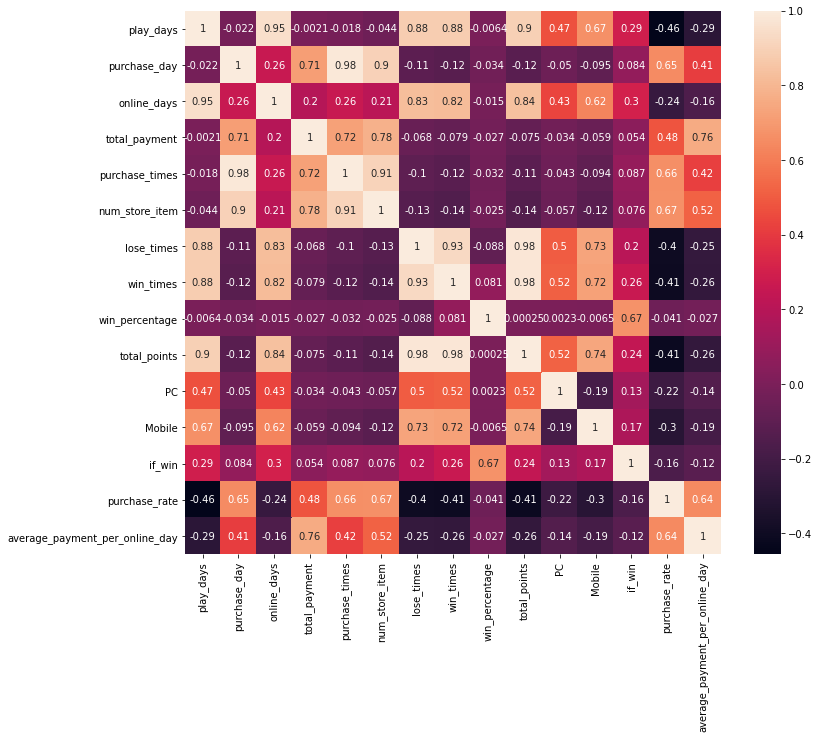

In [42]:
### Heatmap Correlation Matrix 
plt.figure(figsize=(12,10))

corrMatrix = result.corr(method ='pearson' , min_periods = 1)
sn.heatmap(corrMatrix, annot=True)
plt.show()

array([[<AxesSubplot:xlabel='play_days', ylabel='play_days'>,
        <AxesSubplot:xlabel='purchase_day', ylabel='play_days'>,
        <AxesSubplot:xlabel='online_days', ylabel='play_days'>,
        <AxesSubplot:xlabel='total_payment', ylabel='play_days'>,
        <AxesSubplot:xlabel='purchase_times', ylabel='play_days'>,
        <AxesSubplot:xlabel='num_store_item', ylabel='play_days'>,
        <AxesSubplot:xlabel='lose_times', ylabel='play_days'>,
        <AxesSubplot:xlabel='win_times', ylabel='play_days'>,
        <AxesSubplot:xlabel='win_percentage', ylabel='play_days'>,
        <AxesSubplot:xlabel='total_points', ylabel='play_days'>,
        <AxesSubplot:xlabel='PC', ylabel='play_days'>,
        <AxesSubplot:xlabel='Mobile', ylabel='play_days'>,
        <AxesSubplot:xlabel='if_win', ylabel='play_days'>,
        <AxesSubplot:xlabel='purchase_rate', ylabel='play_days'>,
        <AxesSubplot:xlabel='average_payment_per_online_day', ylabel='play_days'>],
       [<AxesSubplot:xlabel='

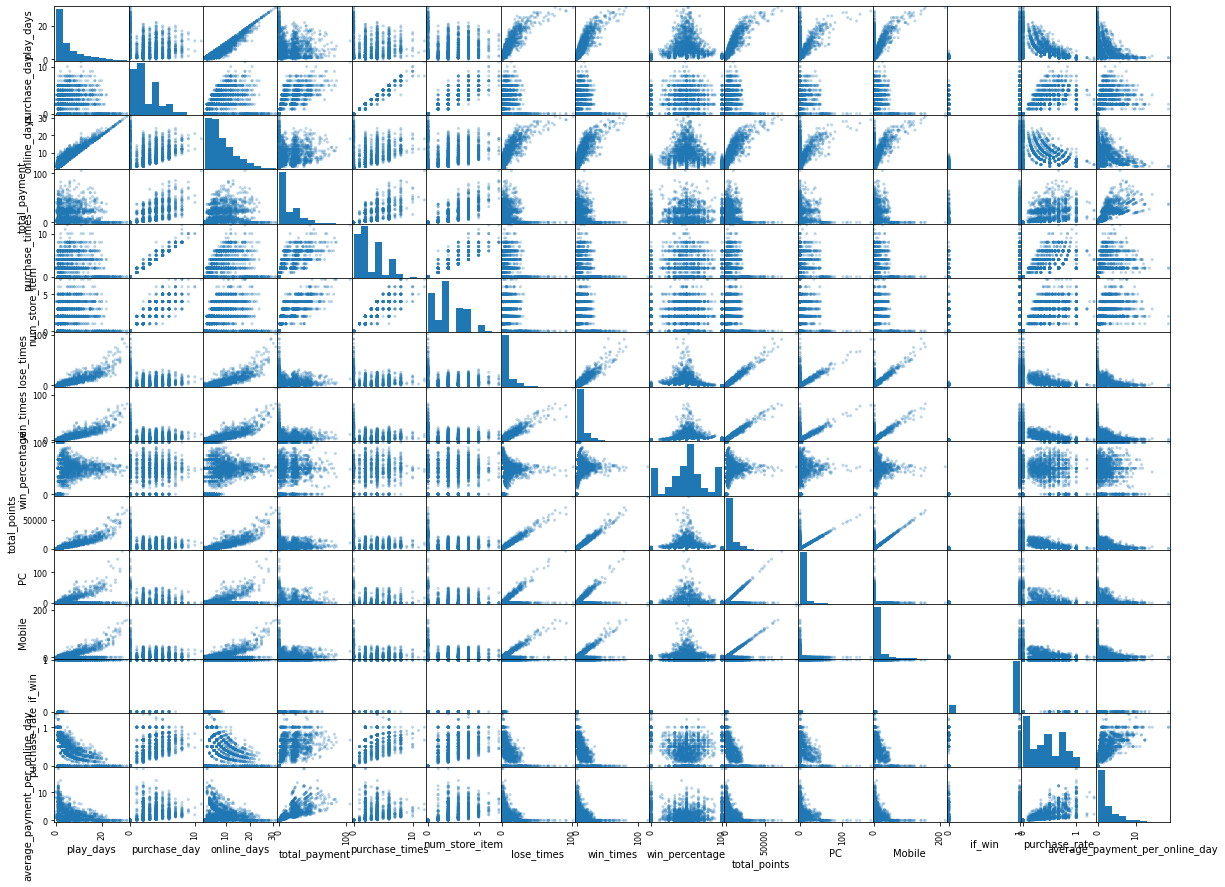

In [43]:
### Scatter Correlation Matrix 
scatter_matrix(result,figsize=(20,15),alpha=0.3)

### Data Modeling

In [47]:
### Construct variables (Select following 5 variables)
X = result.loc[:,['play_days','win_percentage','total_points','PC','Mobile']]
y = result['purchase_rate']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
# used to determine Parameters below
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=5)


### Determine Parameters

In [50]:
from sklearn.metrics import mean_squared_error
# max_feature
for i in range(2,6):
    rfr = RandomForestRegressor(max_features=i, random_state=5)
    rfrmodel = rfr.fit(X_train, y_train)
    y_val_pred = rfrmodel.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(i, ":", mse)
# Best max_features = 5


# max_depth
for i in range(2,10):
    rfr = RandomForestRegressor(max_features=3, max_depth=i, random_state=5)
    rfrmodel = rfr.fit(X_train, y_train)
    y_val_pred = rfrmodel.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(i, ":", mse)
# Best max_depth = 3


# min_samples_split
for i in range(2,6):
    rfr = RandomForestRegressor(max_features=3, max_depth=10, min_samples_split=i, random_state=5)
    rfrmodel = rfr.fit(X_train, y_train)
    y_val_pred = rfrmodel.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(i, ":", mse)
# Best min_samples_split = 4

2 : 0.08549408287684757
3 : 0.0839933725364479
4 : 0.08246140156950481
5 : 0.08181114685642978
2 : 0.06405316968176634
3 : 0.06366638467855422
4 : 0.06391400730869057
5 : 0.06433729305733299
6 : 0.06508903446184189
7 : 0.0657330957026059
8 : 0.06636387895542378
9 : 0.06756378488571682
2 : 0.07047645031412912
3 : 0.07017625777598621
4 : 0.06935862443968417
5 : 0.06990554203760112


### Calculate MSE for regeression

In [51]:
rm = RandomForestRegressor(max_features=5, max_depth=3, min_samples_split=4)
model_Random = rm.fit(X_train, y_train)
y_test_pred = model_Random.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)

0.08300902493398785
